
Imports

In [41]:
import os

import hdbscan
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from langchain_core.messages import SystemMessage
from langchain_core.prompts import (
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate
)

# Import Azure OpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain_openai import AzureChatOpenAI

from newsapi import NewsApiClient

from dotenv import load_dotenv

Load environment variables

In [25]:
# Construct an absolute path to where your .env file is located
dotenv_path = os.path.join(os.getcwd(), '.env')
result = load_dotenv(dotenv_path)
print(result)  # This should print True if the file is loaded successfully

True


Prepare deployed Azure OpenAI models

[Deployed models in Azure Portal](https://oai.azure.com/portal/fdd568fbdff34acfbd92a47db2fa9f36/deployment?tenantid=e23925be-c276-4284-897f-ca99bfbeed44)


In [26]:

embeddings_client = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-small-eastus",
    openai_api_version="2024-02-01",
)

llm_client = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_deployment="gpt-35-turbo-16k",
)

# News

## Get news article from NewsApiClient

In [27]:
newsapi = NewsApiClient(api_key=os.getenv("NEWSAPI_API_KEY"))

sources_1 = [
    "the-washington-post",
]
sources_2 = [
    "the-wall-street-journal",
]
sources_3 = [
    "business-insider",
]
sources_4 = [
    "associated-press",
]
sources_5 = [
    "bloomberg",
]

recent_articles = []

for source in [sources_1, sources_2,sources_3, sources_4,sources_5]:
    recent_articles.extend(newsapi.get_everything(
        sources=",".join(source),
        language="en",
        page_size=100,
    )["articles"])

In [28]:
print(len(recent_articles))

321


Remove none


In [29]:
recent_articles = [a for a in recent_articles if a["title"] is not None and a["description"] is not None]

In [30]:
docs = [
    a["title"] + "\n\n" + a["description"]
    for a in recent_articles
]

print(len(docs))

320


In [31]:
embeddings = embeddings_client.embed_documents(docs)

In [32]:
print(len(embeddings))
print(len(embeddings[0]))

320
1536


## Clustering News Articles

In [53]:

df = pd.DataFrame({
    "title": [article["title"] for article in recent_articles],
    "description": [article["description"] for article in recent_articles],
})


### Cluster with k-means

In [54]:
matrix = np.vstack(embeddings)
matrix.shape

(320, 1536)

In [44]:
n_clusters = 12

In [45]:

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_

#df.groupby("cluster").mean().sort_values()

### Cluster with hbdscan

In [55]:
hdb = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=3).fit(embeddings)
labels = hdb.labels_

Add Cluster labels to dataframe

In [56]:
df["cluster"] = labels

In [57]:
print("Number of articles within cluster: ", df.query("cluster != -1").shape[0])
print("Number of articles without assigned cluster: ", df.query("cluster == -1").shape[0])

Number of articles within cluster:  115
Number of articles without assigned cluster:  205


Remove documents that are not in a cluster

In [50]:
#df = df.query("cluster != -1")

Print numbers of cluster entities

In [58]:
print(df.cluster.value_counts())

cluster
-1     205
 13     22
 9      12
 5      11
 14      9
 2       8
 12      7
 11      6
 7       6
 1       6
 10      5
 15      4
 3       4
 4       4
 8       4
 0       4
 6       3
Name: count, dtype: int64


### t-SNE

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

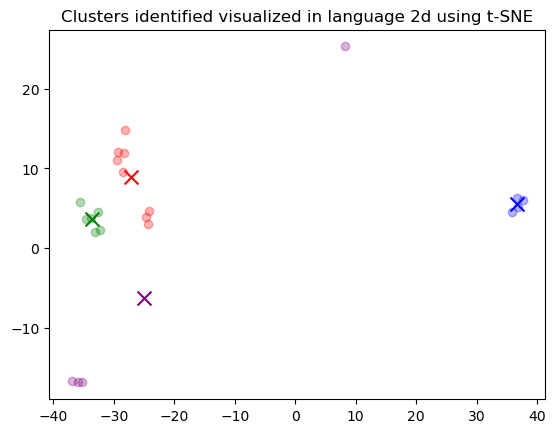

In [63]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


## Cluster naming with GPT

Prepare prompt

In [ ]:
def get_prompt(articles_str):
    system_message = "You're an expert journalist. You're helping me write a compelling topic title for news articles."
    human_message = f"Using the following articles, write a topic title (2-3 sentences) that summarizes them:\n\n{articles_str}"

    prompt = ChatPromptTemplate(
        messages=[
            SystemMessagePromptTemplate(content=system_message),
            HumanMessagePromptTemplate(content=human_message)
        ]
    )
    return prompt

In [ ]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "You're an expert journalist. You're helping me write a compelling topic title for news articles."
            )
        ),
        HumanMessagePromptTemplate.from_template("Using the following articles, write a topic title (2-3 sentences) that summarizes them.\n\nARTICLES:{articles}\n\nTOPIC TITLE:"),
        
    ]
)

In [ ]:
df = df.query("cluster != 4")

In [ ]:
for c in df.cluster.unique():
    #print(c)
    # Generate articles string
    articles_str = "\n".join(
        f"{article['title']}\n{article['description']}\n"
        for article in df.query(f"cluster == {c}").to_dict(orient="records")
    )
    
    # Create prompt
    #prompt = get_prompt(articles_str)
    prompt = chat_template.format_messages(articles=articles_str)
    # Invoke the model and pass the generated prompt
    result = llm_client.invoke(prompt)
    #print(result)

    # Assuming result extraction based on your specific response structure
    df.loc[df.cluster == c, "topic_title"] = result.content

15
2
3
6
12
1
14
11
9
8
7
0
10
5


In [ ]:
for c in df.cluster.unique():
        
    with pd.option_context("display.max_colwidth", None):
        #print cluster id
        print(f"Cluster {c}")
        print(df.query(f"cluster == {c}").topic_title.values[0])
       # display(df.query(f"cluster == {c}").drop(columns=["topic_title"]).head())
# %%


Cluster 15
"Protests on College Campuses: Clashes, Investigations, and Biden's Response"
Cluster 2
Navigating Friendship Turmoil, Provocative Dressing, and Postnuptial Considerations: Insights from Carolyn Hax's Advice Column
Cluster 3
"Washington Nationals' Offensive Surge, Defensive Resurgence, and Pitching Heroics Propel Team to .500 Record"
Cluster 6
"Tesla's Retreat Raises Concerns for Future of US EV Charging Network, While Chinese Materials Disqualify EVs from Tax Credit"
Cluster 12
"SEC Charges Trump Media's Auditor with Massive Fraud, Bans Accounting Firm"
Cluster 1
"Family-Friendly Dining and Entertainment: Best Restaurants and Shows for Kids in the D.C. Area"
Cluster 14
"The Intriguing Dynamics of the 2024 Electorate: Beyond Biden and Trump"
Cluster 11
Mixed Signals: April Jobs Report and Federal Reserve Debates on Rate Cuts
Cluster 9
"Latest Developments in Abortion Laws: Texas Man's Legal Action and Arizona's Repeal of a 19th Century Ban"
Cluster 8
"Apple's Struggles and t

# TikTok data

## Get test data from csv

In [94]:
path_csv= "data/"

df = pd.read_csv(path_csv+'afd_10000_april.csv')
df

,Unnamed: 0,video_id,video_timestamp,video_duration,video_locationcreated,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,...,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified,suggested_words,url,english_transcript,german_transcript
0,0,7355457627083640096,2024-04-08T13:32:26,43,DE,8456,327,369,64700,Ganzes Interview auf X (@AfD). #fyp,...,NaN,NaN,NaN,NaN,NaN,False,adf / afd frauen / afd abschiebungs kalender,https://www.tiktok.com/@annamarinada/video/735...,"that is, with this membership in the AfD. For...",also mit dieser Mitgliedschaft bei der AfD. Si...
1,1,7358884167351930145,2024-04-17T19:09:04,7,DE,5187,666,173,79500,AFD 💙🇩🇪#afd #deutschland #stolzerdeutsche #fyp...,...,NaN,NaN,NaN,NaN,NaN,False,deutsche / deutschland / deutsch deutschland d...,https://www.tiktok.com/@arman.sndzk2/video/735...,NaN,NaN
2,2,7360715244991270176,2024-04-22T17:34:36,13,DE,2660,106,66,12700,#afd #afdverbot #politik #orangensaft #links,...,NaN,NaN,NaN,NaN,NaN,False,NaN,https://www.tiktok.com/@skatch_flp/video/73607...,what is your opinion about blood orange juice?...,wie ist deine Meinung zu Blutorangensaft? ahne...
3,3,7359691434322070817,2024-04-19T23:21:42,61,DE,1915,92,580,28300,Sollte Björn Höcke (AfD) verurteilt werden? #...,...,NaN,NaN,NaN,NaN,NaN,False,björn / höcke / afd zum urteil,https://www.tiktok.com/@yunuscelep_/video/7359...,did you know that it is forbidden to say every...,wusstest du dass es verboten ist zu sagen alle...
4,4,7357689397547945249,2024-04-14T13:52:46,66,DE,1806,22,322,18800,Replying to @Nils AfD,...,NaN,NaN,NaN,NaN,NaN,False,nils / afd erklärung,https://www.tiktok.com/@recoverwithamelie/vide...,funny has no idea about politics believes ever...,lustigte hat keine Ahnung für Politik glaubt a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,89,7356954044801355041,2024-04-12T14:19:17,8,DE,1127,8,185,13300,Sarah eagenknecht hat sogar tiefer geboxt als ...,...,NaN,NaN,NaN,NaN,NaN,False,NaN,https://www.tiktok.com/@afroginparadise/video/...,NaN,NaN
90,90,7352787042750762273,2024-04-01T08:49:21,16,DE,4852,616,353,104200,#abschiebekalender #fyp #AfD #deutschlandzuers...,...,NaN,NaN,NaN,NaN,NaN,False,abschieb kalender / abschiebung afd kalender /...,https://www.tiktok.com/@miguelklaussafd/video/...,NaN,NaN
91,91,7353718946480082209,2024-04-03T21:05:21,28,DE,561,11,661,15600,Tübingen bleibt stabil! Seit heute ist bekannt...,...,NaN,NaN,NaN,NaN,NaN,False,NaN,https://www.tiktok.com/@benedikt_doellmann/vid...,"tübing remains stable, the AfD does not come t...","tübing bleibt stabil, die AfD kommt nicht in u..."
92,92,7353162329967611168,2024-04-02T09:05:36,6,DE,462,12,665,13900,Nobody would question my nationality if i was ...,...,NaN,NaN,NaN,NaN,NaN,False,european nationalism,https://www.tiktok.com/@actually4sm44/video/73...,"So if you're from Africa, why are you white","Wenn Sie also aus Afrika kommen, warum sind S..."


In [95]:
print(len(df))

94


Remove none


In [96]:
docs = [
   str(df["video_description"][a]) + "\n\n" +  str(df["suggested_words"][a]) +"\n\n" +  str(df["german_transcript"][a])
    for a in range(len(df))
]

print(len(docs))

94


In [97]:
embeddings = embeddings_client.embed_documents(docs)

In [98]:
print(len(embeddings))
print(len(embeddings[0]))

94
1536


NameError: name 'embeddings' is not defined

## Clustering posts

Cluster with hbdscan

In [99]:
hdb = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=3).fit(embeddings)

In [100]:
hdb.labels_ #here I see that the clustering didn't work (only one cluster) and stopped

array([-1,  1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1,
       -1,  0, -1, -1,  0,  1,  1, -1, -1,  1,  0, -1, -1, -1, -1, -1, -1,
        0, -1,  0, -1,  1,  2, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1,  2, -1,  2,  0, -1, -1, -1,  2, -1,  0, -1, -1, -1,
        2, -1, -1, -1,  0, -1,  2,  2,  2, -1,  0,  0, -1, -1,  0, -1, -1,
        0, -1, -1, -1, -1,  1, -1, -1, -1])

Add Cluster labels to dataframe

In [101]:
# add cluster id to dataframe
df["cluster"] = hdb.labels_
print("Number of posts within cluster: ", df.query("cluster != -1").shape[0])

print("Number of posts without assigned cluster: ", df.query("cluster == -1").shape[0])


Number of articles within cluster:  32
Number of articles without assigned cluster:  62


Remove documents that are not in a cluster

In [102]:
df = df.query("cluster != -1")

Print numbers of cluster entities

In [103]:
print(df.cluster.value_counts())


cluster
0    18
2     8
1     6
Name: count, dtype: int64


In [104]:
# get rows with cluster id 0 and show urls
df.query("cluster == 0")

,Unnamed: 0,video_id,video_timestamp,video_duration,video_locationcreated,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,...,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified,suggested_words,url,english_transcript,german_transcript,cluster
3,3,7359691434322070817,2024-04-19T23:21:42,61,DE,1915,92,580,28300,Sollte Björn Höcke (AfD) verurteilt werden? #...,...,NaN,NaN,NaN,NaN,False,björn / höcke / afd zum urteil,https://www.tiktok.com/@yunuscelep_/video/7359...,did you know that it is forbidden to say every...,wusstest du dass es verboten ist zu sagen alle...,0
5,5,7359628606286351648,2024-04-19T19:17:50,210,DE,1190,17,920,35300,NaN,...,NaN,NaN,NaN,NaN,False,NaN,https://www.tiktok.com/@gastronomicus2/video/7...,"yes, what can I tell you, I kicked out an AFDl...","ja, was soll ich euch sagen, ich hab n AFDler ...",0
14,14,7361436116064537889,2024-04-24T16:11:57,58,DE,3522,251,130,24100,So stark ist die AfD unter der Generation Z.,...,NaN,NaN,NaN,NaN,False,generation z / genz / gen z moments,https://www.tiktok.com/@jungefreiheit/video/73...,the youth is on the right. yes indeed. the AfD...,die Jugend ist rechts. ja tatsächlich. die AfD...,0
15,15,7356948863653088544,2024-04-12T13:59:09,61,DE,4975,173,605,63000,#höcke #voigt #cdu #afd #thüringen,...,NaN,NaN,NaN,NaN,False,höcke / cdu / thüringen / yunus celep,https://www.tiktok.com/@yunuscelep_/video/7356...,so what was that TV duel yesterday please Björ...,also was war das bitte gestern für ein TV Duel...,0
18,18,7357016678846270753,2024-04-12T18:22:16,592,DE,847,53,150,12300,#afd #spd #cdu #csu #grüne #fdp #foryou #viral...,...,NaN,NaN,NaN,NaN,False,NaN,https://www.tiktok.com/@tattootom22/video/7357...,Duel at weltnachrichten. TV between Höcke AfD...,Duell bei weltnachrichten. TV zwischen Höcke A...,0
21,21,7356498063088815392,2024-04-11T08:49:51,278,DE,3554,145,693,29800,Antwort auf @Peter #answer #antwort,...,NaN,NaN,NaN,NaN,False,NaN,https://www.tiktok.com/@frieda_friedrich/video...,"since the Peter, who was almost the only one w...","da der Peter, der fast der einzige war, der ge...",0
27,27,7356924156899822880,2024-04-12T12:23:19,122,DE,0,0,817,0,Das TV-Duell zwischen den Spitzenkandidaten Vo...,...,NaN,NaN,NaN,NaN,False,höcke / afd wahlen / thüringen / cdu / cdu vs ...,https://www.tiktok.com/@danoclock/video/735692...,you have the TV duel between CDU Vogt and Bern...,habt ihr das TV Duell zwischen CDU Vogt und Be...,0
34,34,7362177684341902625,2024-04-26T16:09:39,77,DE,2003,28,83,14400,"Was glaubt ihr, woran das liegt? 🫠 #politik #l...",...,NaN,NaN,NaN,NaN,False,ampel regierung / afd wahlen / adf / ampel reg...,https://www.tiktok.com/@thesimondavid/video/73...,"22% of young people would say, according to a...",22 % der jungen Leute würden laut einer Umfrag...,0
36,36,7359523493836328225,2024-04-19T12:29:59,706,DE,5193,268,462,65900,Alice Weidel muss unsere nächste Kanzlerin wer...,...,NaN,NaN,NaN,NaN,False,aliceweidel / Alice Weidel Edit / aliceweidel_...,https://www.tiktok.com/@afd_bluey/video/735952...,"I, I'm not giving the speech I'm giving right...","ich, ich halte nicht die Rede, die ich gerade....",0
43,43,7360055806886268192,2024-04-20T22:55:38,79,DE,4138,352,181,42700,#maximiliankrah #krah #afd #cdu #eu #europa #v...,...,NaN,NaN,NaN,NaN,False,Maximilian Krah / Maximilian / cdu / maximilia...,https://www.tiktok.com/@jason.afd/video/736005...,why do you want to see the CDU destroyed? beca...,warum willst du die CDU zerstört sehen? weil w...,0


## Cluster naming with GPT

Prepare prompt

In [105]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "Du bist ein Experte im Schreiben. Du hilfst mir, einen überzeugenden Titel für mehrere ähnliche TikTok-Beiträge zu schreiben."
            )
        ),
        HumanMessagePromptTemplate.from_template("Schreibe anhand der folgenden deutschen Transkripte und Beschreibungen von Tiktok-Videos einen Thementitel (2-3 Sätze), der sie zusammenfasst: \n\nPOSTS:{posts}\n\nTOPIC TITLE:"),
    ]
)

In [106]:
for c in df.cluster.unique():
    print(c)
    # Generate posts string
    posts_str = "\n".join(
        f"{post['video_description']}\n{post['german_transcript']}\n" #\n{post['suggested_words']}
        for post in df.query(f"cluster == {c}").to_dict(orient="records")
    )

    # limit str to maximum token length of model 16384
    posts_str = posts_str[:16384]
    # Create prompt
    #prompt = get_prompt(articles_str)
    prompt = chat_template.format_messages(posts=posts_str)
    # Invoke the model and pass the generated prompt
    result = llm_client.invoke(prompt)
    #print(result)

    # Assuming result extraction based on your specific response structure
    df.loc[df.cluster == c, "topic_title"] = result.content

1


/var/folders/ng/bpb66jzj5d59g10n121_hj6h0000gn/T/ipykernel_65391/3150023226.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df.cluster == c, "topic_title"] = result.content


0
2


In [107]:
for c in df.cluster.unique():
        
    with pd.option_context("display.max_colwidth", None):
        #print cluster id
        print(f"Cluster {c}")
        print(df.query(f"cluster == {c}").topic_title.values[0])
       # display(df.query(f"cluster == {c}").drop(columns=["topic_title"]).head())
# %%


Cluster 1
"Die AfD in Deutschland: Für einen politischen Wechsel und ein stolzes Deutschland"
Cluster 0
Die AfD im Fokus: Von Verurteilungen bis zur Generation Z - Eine Analyse aktueller TikTok-Beiträge #afd #höcke #cdu #generationz
Cluster 2
"Die AfD im Wahlkampf: Mut zur Wahrheit für Deutschland!"


In [108]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re
import string
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthiaskiller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthiaskiller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [109]:
def preprocess_text(text):
    # Checking if the input is a string
    if isinstance(text, str):
        # Converting to lowercase
        text = text.lower()
        # Removing punctuation
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        # Removing non-alphabetic characters
        text = re.sub('\W', ' ', text)
        # Removing long strings of whitespace
        text = re.sub('\s+', ' ', text).strip()
        # Removing äh
        text = re.sub('äh', ' ', text).strip()
        # Removing mal
        text = re.sub('mal', ' ', text).strip()
        # Removing ja
        text = re.sub('ja', ' ', text).strip()
        # Tokenizing the text
        words = word_tokenize(text)
        # Removing stopwords
        stop_words = set(stopwords.words('german'))
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    else:
        # Asking to return an empty string if the input is not a string
        return ''

In [110]:
cleaned_docs = [preprocess_text(docs[i]) for i in range(len(docs))]

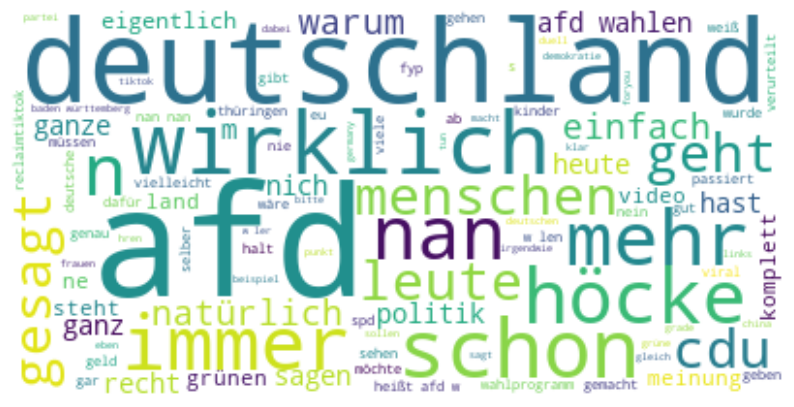

In [111]:
wordcloud_signature = WordCloud(background_color = 'white', max_words = 100).generate(' '.join(cleaned_docs))

# Displaying the word cloud for the signatures
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_signature, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")
